# Resnet50

In [1]:
import glob
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

### Loading and pre-processing the data

In [2]:
train_image = []
train_annotation = []

image_file = glob.glob("/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))
    
    seperate_path = i.split('.')
    seperate_path[1] = '.txt'
    
    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

### Displaying sample images

1359


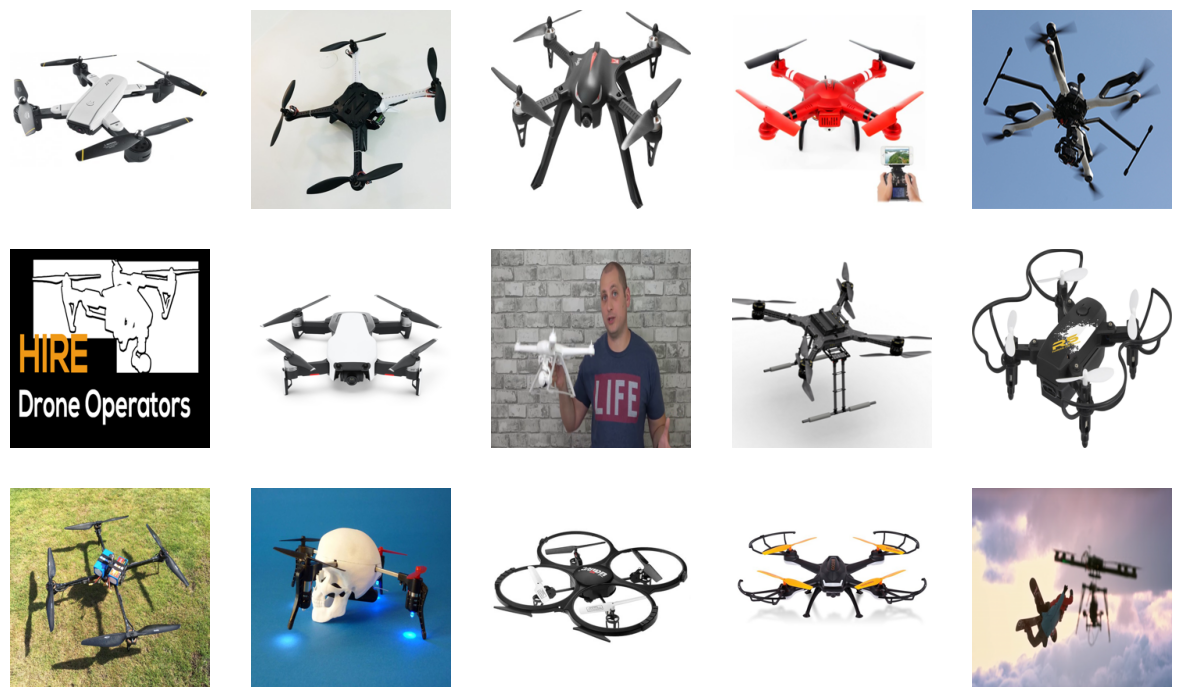

In [3]:
print(len(train_image))

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

### Splitting the data into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split
data = np.array(train_image, dtype='float32') / 255.0   # memory not sufficient !!
targets = np.array(train_annotation, dtype='float32')

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((1359, 256, 256, 3), (1359, 4))

# Resnet50

### Building model

In [5]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input

def build_resnetmodel():
    resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    resnet.trainable = True

    flatten = resnet.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    resnetmodel = Model(inputs=resnet.input, outputs=bboxHead)
    
    return resnetmodel

resnetmodel = build_resnetmodel()

resnetmodel.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

### Compiling and training the model

In [6]:
resnetmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("RESNETModel.h5", verbose=1)

historyresnet= resnetmodel.fit(
    trainImages, trainTargets,
    validation_split=0.2,
    batch_size= 16,
    epochs=50,
    verbose=1,
    callbacks=[save_best])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 9.7717 - accuracy: 0.3487
Epoch 1: saving model to RESNETModel.h5
62/62 [==============================] - 52s 186ms/step - loss: 9.7717 - accuracy: 0.3487 - val_loss: 1.4080 - val_accuracy: 0.3224
Epoch 2/50
61/62 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.5984
Epoch 2: saving model to RESNETModel.h5
62/62 [==============================] - 10s 162ms/step - loss: 0.0590 - accuracy: 0.5982 - val_loss: 0.5071 - val_accuracy: 0.6449
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.6711
Epoch 3: saving model to RESNETModel.h5
62/62 [==============================] - 10s 159ms/step - loss: 0.0285 - accuracy: 0.6718 - val_loss: 0.3176 - val_accuracy: 0.1347
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.7141
Epoch 4: saving model to RESNETModel.h5
62/62 [==============================] - 10s 160ms/step - loss: 0.02

### Predictions on test images

In [7]:
resnetmodel = tf.keras.models.load_model('./RESNETModel.h5')

resnetmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 1s 1s/step


array([[0.567708  , 0.46718588, 0.98977786, 0.41325504],
       [0.40265653, 0.47678795, 0.9119335 , 0.5577638 ],
       [0.48284718, 0.5455847 , 0.81258035, 0.76771945],
       [0.5506978 , 0.44231674, 0.73650265, 0.68395555],
       [0.44613954, 0.46446815, 0.8740673 , 0.56490695],
       [0.50980926, 0.489023  , 0.92775   , 0.4440956 ],
       [0.4342036 , 0.5452972 , 0.32726213, 0.38437605],
       [0.5172956 , 0.41123036, 0.6300465 , 0.80614996],
       [0.52449477, 0.358331  , 0.63053596, 0.6700781 ],
       [0.51029813, 0.41288736, 0.7979264 , 0.56606597]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.9089979529380798
Final Validation Accuracy: 0.7755101919174194


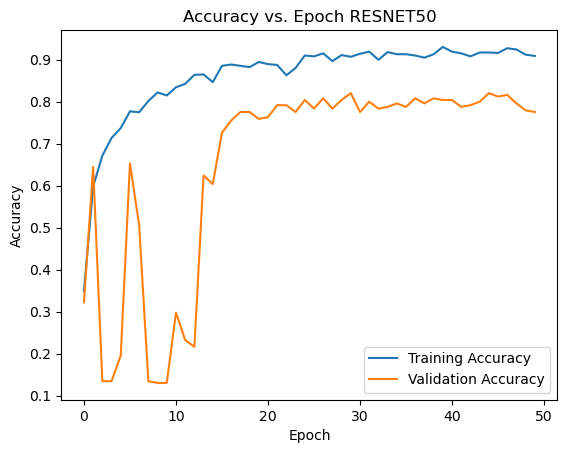

In [8]:
print('Final Training Accuracy:', historyresnet.history['accuracy'][-1])
print('Final Validation Accuracy:', historyresnet.history['val_accuracy'][-1])

plt.plot(historyresnet.history['accuracy'], label='Training Accuracy')
plt.plot(historyresnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch RESNET50')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.0023619208950549364
Final Validation Loss: 0.015314965508878231


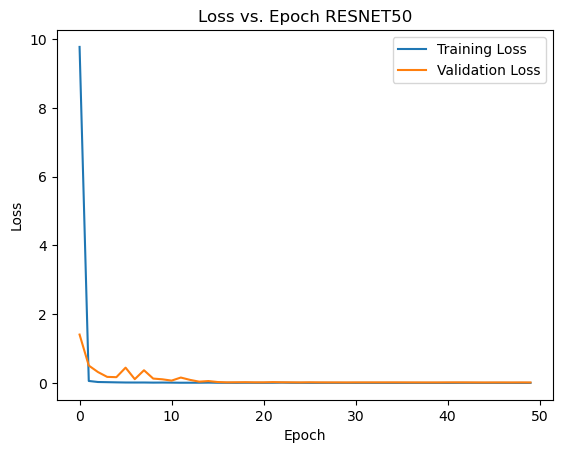

In [9]:
print('Final Training Loss:', historyresnet.history['loss'][-1])
print('Final Validation Loss:', historyresnet.history['val_loss'][-1])

plt.plot(historyresnet.history['loss'], label='Training Loss')
plt.plot(historyresnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch RESNET50')
plt.legend()
plt.show()

### Evaluating on test images

In [10]:
loss, accuracy = resnetmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 2s 94ms/step - loss: 0.0122 - accuracy: 0.8015
Test Loss: 0.012235049158334732
Test Accuracy: 0.8014705777168274


In [ ]:
import numpy as np
import cv2
from PIL import Image
from IPython.display import display

# Load the trained ResNet-50 model
resnet50_model = tf.keras.models.load_model('/kaggle/working/RESNETModel.h5')

# Function to detect drone in an image using the trained model
def detect_drone_resnet50(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((256, 256))
    img_array = np.asarray(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Retrieve coordinates
    startX, startY, endX, endY = predictions[0]
    
    # Load original image
    original_image = cv2.imread(image_path)
    
    # Scale coordinates to match original image size
    height, width, _ = original_image.shape
    startX, startY, endX, endY = int(startX * width), int(startY * height), int(endX * width), int(endY * height)
    
    # Calculate the center of the bounding box
    center_x = (startX + endX) // 2
    center_y = (startY + endY) // 2
    
    # Enlarge the bounding box to cover the entire drone
    box_width = endX - startX
    box_height = endY - startY
    enlarged_width = int(box_width * 20)
    enlarged_height = int(box_height * 20 )
    
    new_startX = max(0, int(center_x - enlarged_width // 2))
    new_startY = min(height, int(center_y - enlarged_height // 2))  # Move the box down
    new_endX = min(width, int(center_x + enlarged_width // 2))
    new_endY = min(height, int(center_y + enlarged_height // 2))
    
    # Draw bounding box
    cv2.rectangle(original_image, (new_startX, new_startY), (new_endX, new_endY), (0, 255, 0), 2)
    
    # Convert image to RGB (OpenCV uses BGR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Display the image with enlarged bounding box
    display(Image.fromarray(original_image))

# Test the function on a test image
image_path = "/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/0004.jpg"
detect_drone_resnet50(image_path, resnet50_model)


1/1 [==============================] - 1s 949ms/step


# Resnet32

In [11]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Loading and pre-processing the data
train_image = []
train_annotation = []

image_file = glob.glob("/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/*.jpg")

In [12]:
for i in image_file:
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))
    
    separate_path = i.split('.')
    separate_path[1] = '.txt'
    
    with open(separate_path[0]+separate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

In [13]:
# Splitting the data into training and testing sets
data = np.array(train_image, dtype='float32') / 255.0
targets = np.array(train_annotation, dtype='float32')

trainImages, testImages, trainTargets, testTargets = train_test_split(data, targets, test_size=0.10, random_state=42)

In [14]:
# Building ResNet32 model
def residual_block(x, filters, strides=1):
    shortcut = x
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet32():
    input_img = Input(shape=(256, 256, 3))
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = AveragePooling2D(pool_size=(8, 8))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(4, activation='linear')(x)
    model = Model(inputs=input_img, outputs=output)
    return model

resnet32_model = build_resnet32()
resnet32_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [15]:
# Compiling the model
resnet32_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

# Training the model
save_best = ModelCheckpoint("RESNET32Model.h5", verbose=1, save_best_only=True)

history = resnet32_model.fit(
    trainImages, trainTargets,
    validation_split=0.2,
    batch_size=16,
    epochs=50,
    verbose=1,
    callbacks=[save_best])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.5194
Epoch 1: val_loss improved from inf to 0.80694, saving model to RESNET32Model.h5
62/62 [==============================] - 18s 72ms/step - loss: 0.0931 - accuracy: 0.5194 - val_loss: 0.8069 - val_accuracy: 0.2041
Epoch 2/50
61/62 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.5809
Epoch 2: val_loss improved from 0.80694 to 0.16403, saving model to RESNET32Model.h5
62/62 [==============================] - 4s 65ms/step - loss: 0.0381 - accuracy: 0.5798 - val_loss: 0.1640 - val_accuracy: 0.4041
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.6414
Epoch 3: val_loss improved from 0.16403 to 0.13051, saving model to RESNET32Model.h5
62/62 [==============================] - 4s 58ms/step - loss: 0.0301 - accuracy: 0.6401 - val_loss: 0.1305 - val_accuracy: 0.1143
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.0277 -

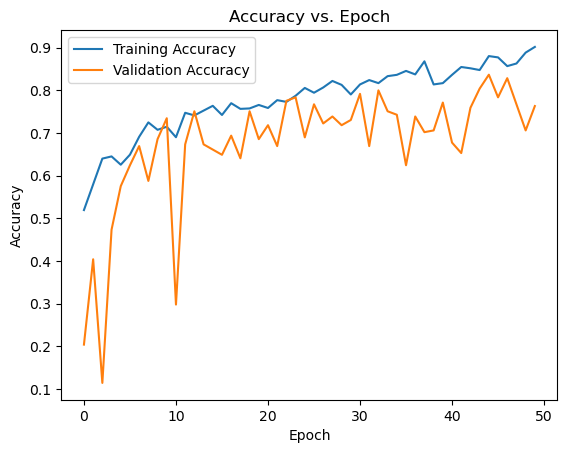

In [16]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

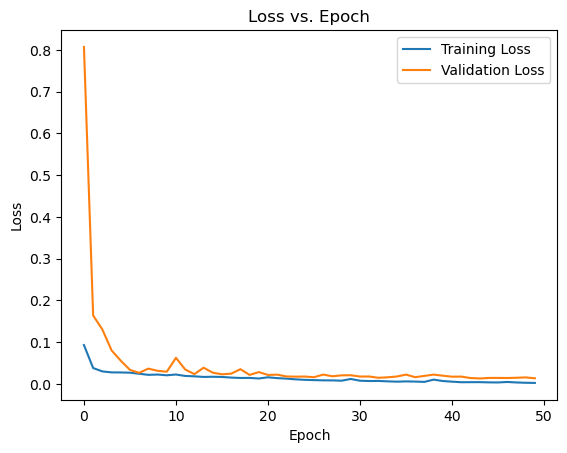

In [17]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()


In [18]:
# Evaluating on test images
resnet32_model = tf.keras.models.load_model('RESNET32Model.h5')
loss, accuracy = resnet32_model.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 1s 35ms/step - loss: 0.0135 - accuracy: 0.8015
Test Loss: 0.013529397547245026
Test Accuracy: 0.8014705777168274


## Testing the code

1/1 [==============================] - 0s 420ms/step


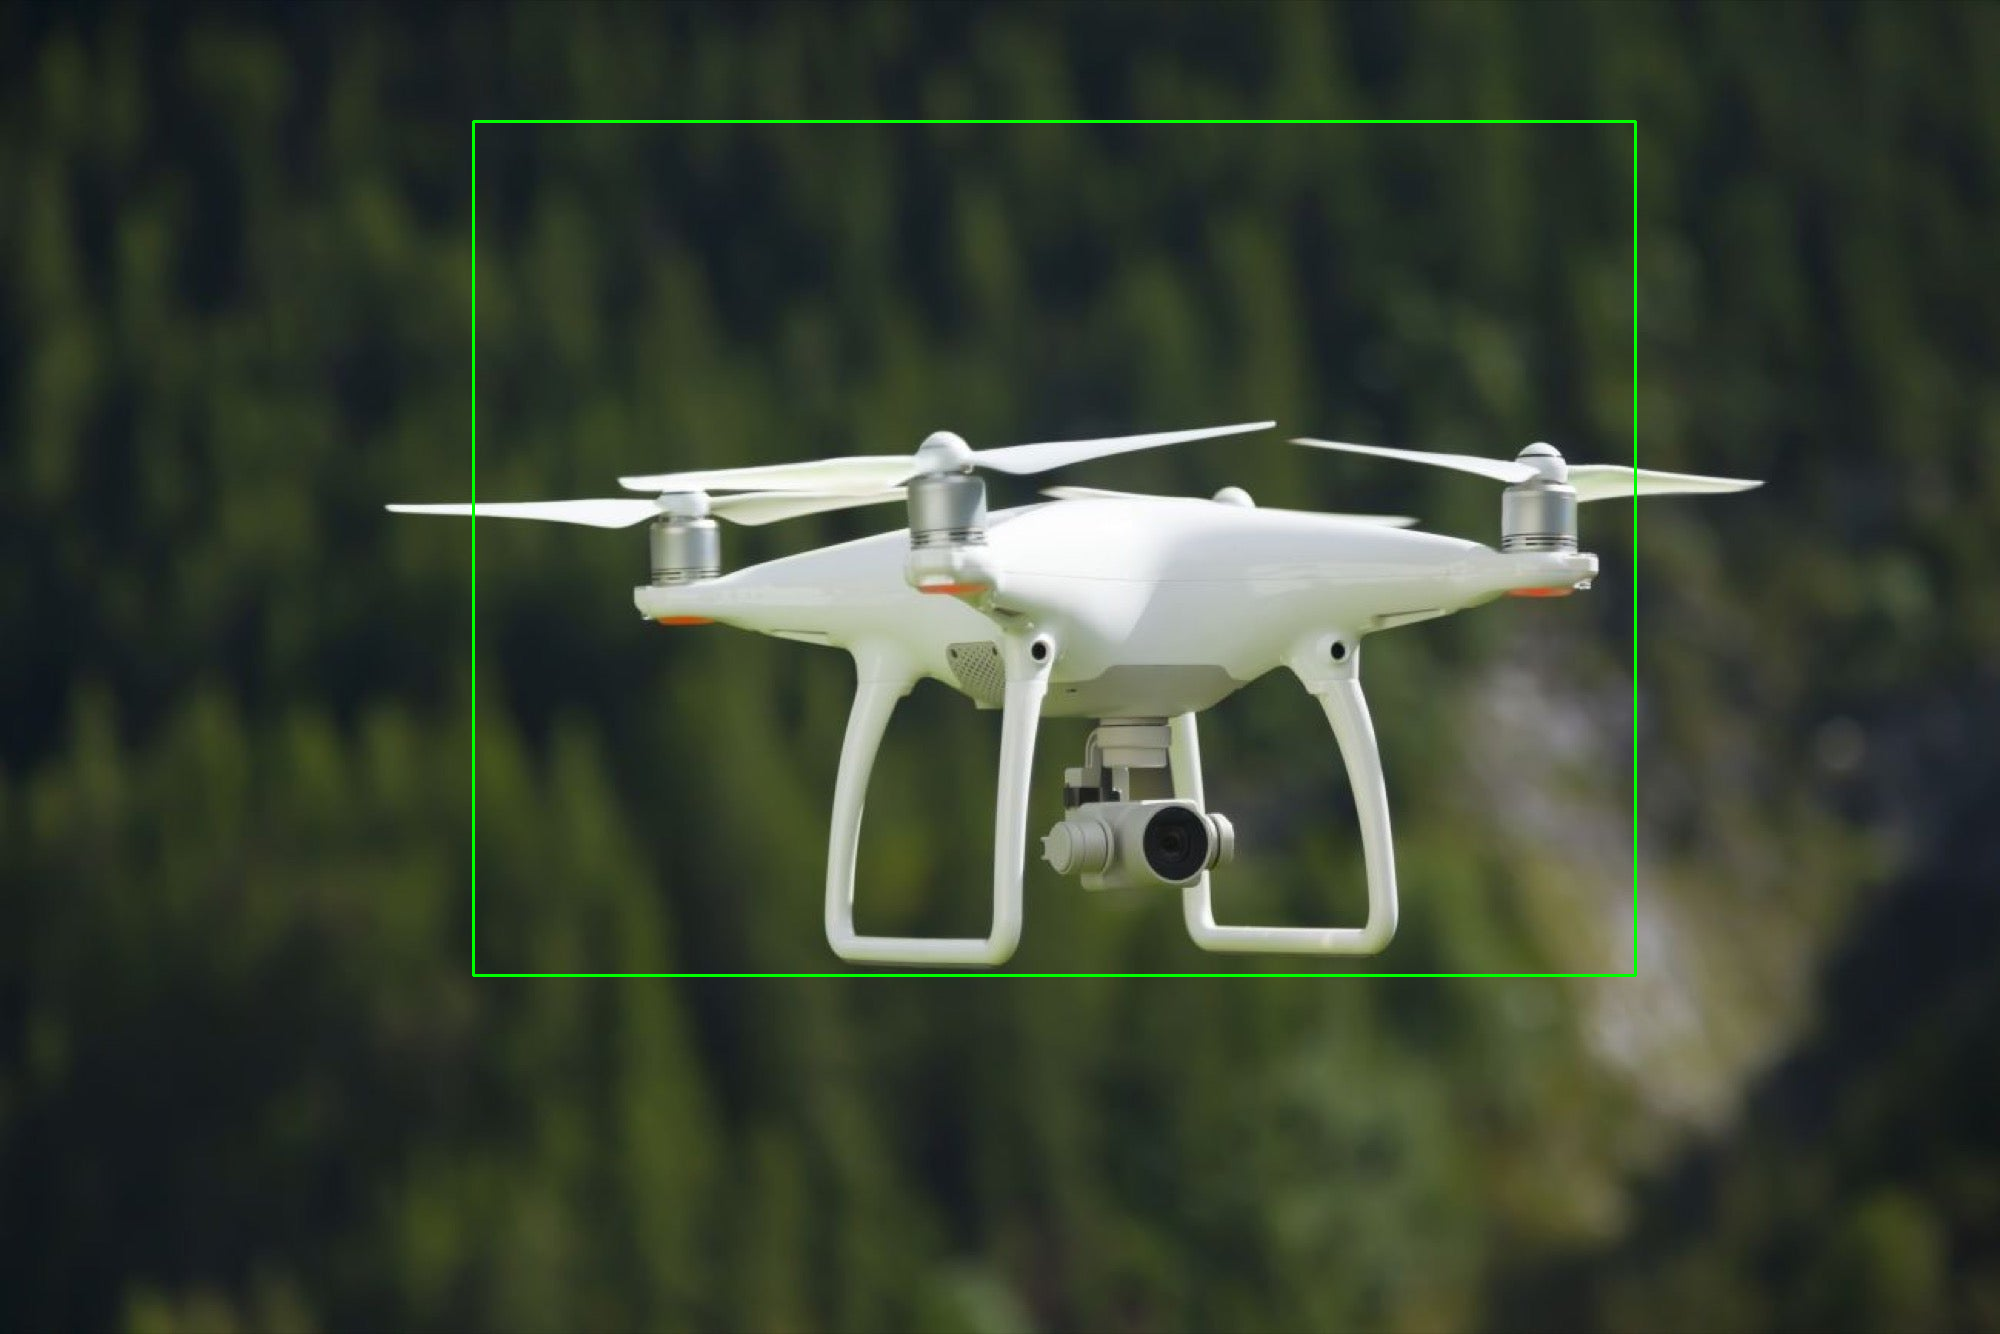

In [30]:
import numpy as np
import cv2
from PIL import Image
from IPython.display import display

# Load the trained ResNet-32 model
resnet32_model = tf.keras.models.load_model('RESNET32Model.h5')

# Function to detect drone in an image using the trained model
def detect_drone(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((256, 256))
    img_array = np.asarray(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Retrieve coordinates
    startX, startY, endX, endY = predictions[0]
    
    # Load original image
    original_image = cv2.imread(image_path)
    
    # Scale coordinates to match original image size
    height, width, _ = original_image.shape
    startX, startY, endX, endY = int(startX * width), int(startY * height), int(endX * width), int(endY * height)
    
    # Calculate the center of the bounding box
    center_x = (startX + endX) // 2
    center_y = (startY + endY) // 2
    
    # Enlarge the bounding box to cover the entire drone
    box_width = endX - startX
    box_height = endY - startY
    enlarged_width = int(box_width * 7)
    enlarged_height = int(box_height * 7)
    
    new_startX = max(0, int(center_x - enlarged_width // 2))
    new_startY = min(height, int(center_y - enlarged_height // 2))  # Move the box down
    new_endX = min(width, int(center_x + enlarged_width // 2))
    new_endY = min(height, int(center_y + enlarged_height // 2))
    
    # Draw bounding box
    cv2.rectangle(original_image, (new_startX, new_startY), (new_endX, new_endY), (0, 255, 0), 2)
    
    # Convert image to RGB (OpenCV uses BGR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Display the image with enlarged bounding box
    display(Image.fromarray(original_image))

# Test the function on a test image
image_path = "/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/0004.jpg"
detect_drone(image_path, resnet32_model)
